# <center>SFML/INFO-F422: Statistical foundations of machine learning</center>

# <center>Regression Part</center>

Name: Mathieu Parmentier & Nini

Python version: 3.6

Date: XXXXX


## Introduction

# Objective and strategy 

## Material and method

### Data loading:

In [24]:
import pandas as pd
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

data = datasets.load_boston()
X = pd.DataFrame(data.data, columns=data.feature_names)
Y = pd.DataFrame(data.target, columns=["MEDV"])

Y = np.array(Y)
Y = np.reshape(Y,len(Y))

Exploration of the data

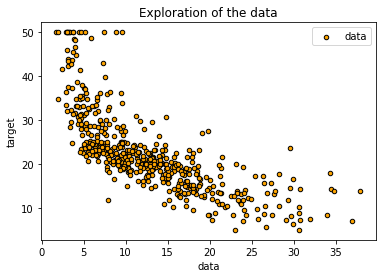

In [35]:
plt.figure()
plt.scatter(X['LSTAT'], Y, s=20, edgecolor="black",c="orange", label="data")

plt.xlabel("data")
plt.ylabel("target")
plt.title("Exploration of the data")
plt.legend()
plt.show()

### 1) Algorithm : Support vector machine (SVM)  → source: adaptation du cours et de scikit learn

Importation of all the different libraries required

In [25]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

Training of the model

In [26]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size= .25, random_state=25)

svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_lin = SVR(kernel='linear', C=100, gamma='auto')
#svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,coef0=1)

svr_rbf.fit(x_train,y_train)
svr_lin.fit(x_train,y_train)
#svr_poly.fit(x_train,y_train)

SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

Quality test

Plot of the results

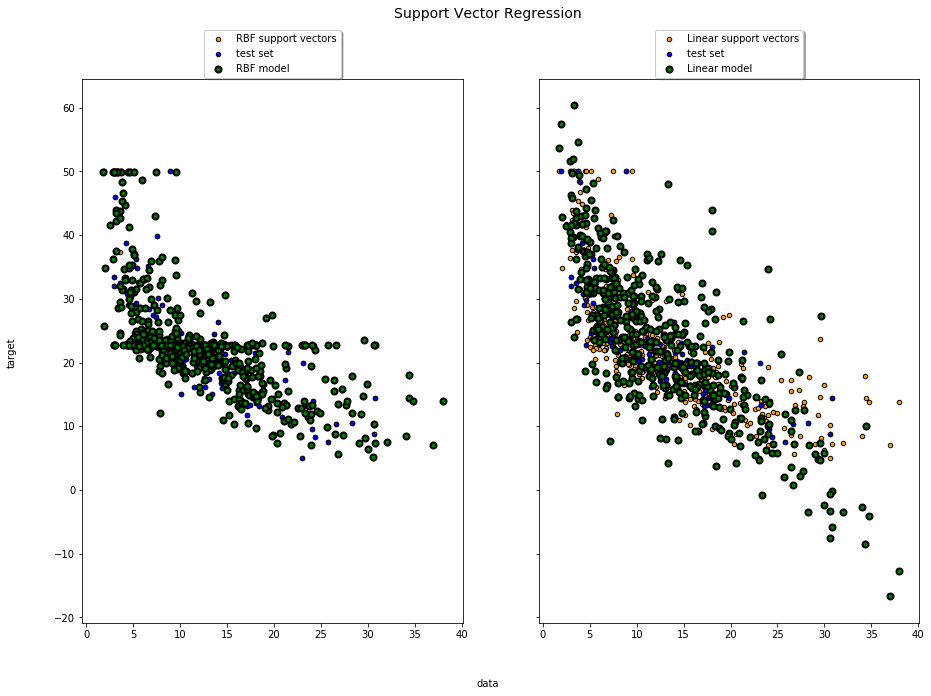

In [28]:
lw = 2

svrs = [svr_rbf, svr_lin]
kernel_label = ['RBF', 'Linear']


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10), sharey=True)
for ix, svr in enumerate(svrs):
    axes[ix].scatter(X['LSTAT'], Y, edgecolor="black",color="orange", s=20,
                     label='{} support vectors'.format(kernel_label[ix]))
    axes[ix].scatter(x_test['LSTAT'], y_test, edgecolor="black", color="blue", s=20,
                     label='test set')
    axes[ix].scatter(X['LSTAT'], svr.predict(X), edgecolor="black", color="green", lw=lw,
                  label='{} model'.format(kernel_label[ix]))
    axes[ix].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
                    ncol=1, fancybox=True, shadow=True)

fig.text(0.5, 0.04, 'data', ha='center', va='center')
fig.text(0.06, 0.5, 'target', ha='center', va='center', rotation='vertical')
fig.suptitle("Support Vector Regression", fontsize=14)
plt.show()

### 2) Algorithm : Decision Tree Regression  → source: adaptation du cours et de scikit learn

Importation of all the different libraries required

In [15]:
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score

Training of the model

In [16]:
x_train,x_test,y_train, y_test = train_test_split(X,Y,test_size=.25,random_state=25)
regressor = DecisionTreeRegressor(max_depth=2)
regressor.fit(x_train, y_train)
# Y_pred = regressor.predict(X_test)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

Quality control

In [21]:

######################################
### cross-validation               ###
######################################

######################################
### decide on the depth            ###
######################################



Plot of the results

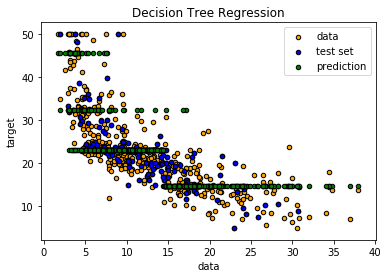

In [17]:
plt.figure()
plt.scatter(X['LSTAT'], Y, s=20, edgecolor="black",c="orange", label="data")
plt.scatter(x_test['LSTAT'], y_test, s=20, edgecolor="black",c="blue", label="test set")
plt.scatter(X['LSTAT'], regressor.predict(X), s=20, edgecolor="black",c="green", label="prediction")
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

### 3) Algorithm : Neural network Regression  → source: de scikit learn

Importation of all the different libraries required

In [18]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

Training of the model

In [19]:
x_train, x_test, y_train, y_test = train_test_split(X, Y,random_state=1)

regr = MLPRegressor(random_state=1, max_iter=500).fit(x_train, y_train)


# regr.score(x_test, y_test)

C:\Anaconda\envs\Python Scripts\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Quality control

Plot of the results

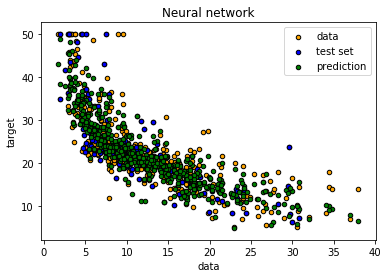

In [20]:
plt.figure()
plt.scatter(X['LSTAT'], Y, s=20, edgecolor="black",c="orange", label="data")
plt.scatter(x_test['LSTAT'], y_test, s=20, edgecolor="black",c="blue", label="test set")
plt.scatter(X['LSTAT'], regr.predict(X), s=20, edgecolor="black",c="green", label="prediction")

plt.xlabel("data")
plt.ylabel("target")
plt.title("Neural network")
plt.legend()
plt.show()

### 4) Algorithm : Nearest neighbors regression  → source: de scikit learn

In [29]:
from sklearn import neighbors

Training of the model

In [30]:
n_neighbors = 5

knn_uniform = neighbors.KNeighborsRegressor(n_neighbors, weights='uniform')
knn_distance = neighbors.KNeighborsRegressor(n_neighbors, weights='distance')

knn_uniform.fit(x_train, y_train) 
knn_distance.fit(x_train, y_train)


#for i, weights in enumerate(['uniform', 'distance']):
    #knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
    #y_ = knn.fit(X, y).predict(T)

    #plt.subplot(2, 1, i + 1)
    #plt.scatter(X, y, color='darkorange', label='data')
    #plt.plot(T, y_, color='navy', label='prediction')
   # plt.axis('tight')
  #  plt.legend()
 #   plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors,weights))

#plt.tight_layout()
#plt.show()

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='distance')

Quality control

Plot of the results

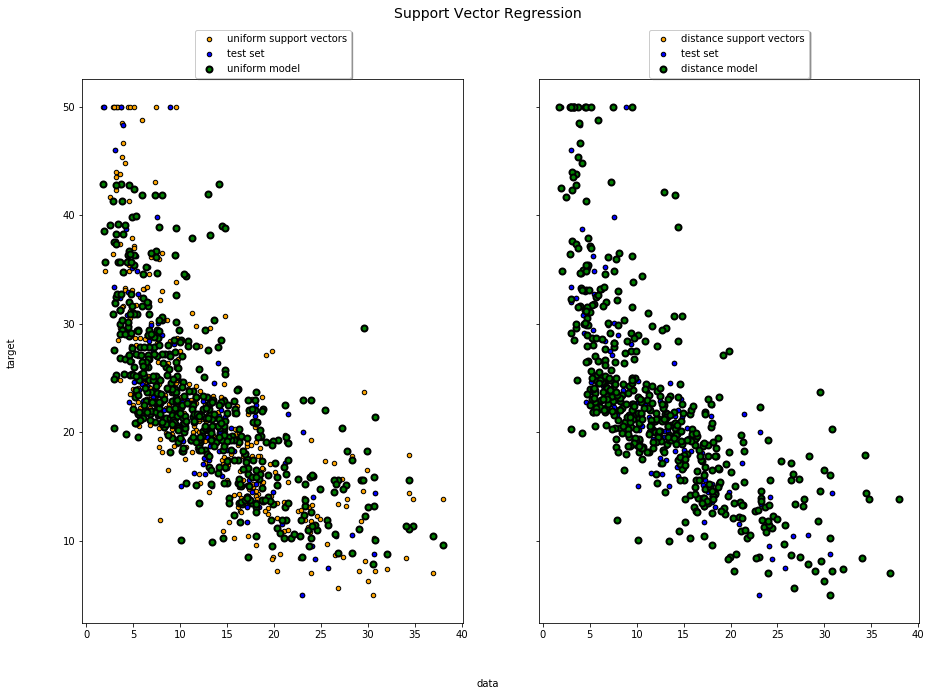

In [32]:
lw = 2

knn = [knn_uniform, knn_distance]
kernel_label = ['uniform', 'distance']


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10), sharey=True)
for ix, knn in enumerate(knn):
    axes[ix].scatter(X['LSTAT'], Y, edgecolor="black",color="orange", s=20,
                     label='{} support vectors'.format(kernel_label[ix]))
    axes[ix].scatter(x_test['LSTAT'], y_test, edgecolor="black", color="blue", s=20,
                     label='test set')
    axes[ix].scatter(X['LSTAT'], knn.predict(X), edgecolor="black", color="green", lw=lw,
                  label='{} model'.format(kernel_label[ix]))
    axes[ix].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
                    ncol=1, fancybox=True, shadow=True)

fig.text(0.5, 0.04, 'data', ha='center', va='center')
fig.text(0.06, 0.5, 'target', ha='center', va='center', rotation='vertical')
fig.suptitle("Support Vector Regression", fontsize=14)
plt.show()

## Results & Discusion

## Conclusion 

## Bibliography

 Lecture + ...